# Q-Learning vs SARSA: On-Policy vs Off-Policy

**Goal**: Understand the difference between on-policy and off-policy learning through hands-on comparison.

## Key Concepts
- **Off-policy (Q-learning)**: Learn about the *optimal* policy while following an exploratory policy
- **On-policy (SARSA)**: Learn about the policy *you're actually following*

## The Core Difference

| Algorithm | Update Target | Learns About |
|-----------|--------------|---------------|
| Q-Learning | `r + γ max Q(s', a')` | Optimal policy |
| SARSA | `r + γ Q(s', a')` where a' is the actual next action | Current policy |

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict

# Import our agents
from rl_lab.agents import QLearningAgent, SarsaAgent, ExpectedSarsaAgent

np.set_printoptions(precision=3)

---
## 1. The Algorithms

### Q-Learning (Off-Policy)
```
Q(s, a) ← Q(s, a) + α [r + γ max_a' Q(s', a') - Q(s, a)]
```

- Uses **max** over next actions → learns optimal Q regardless of behavior
- Can learn from old data, demonstrations, other agents
- May overestimate Q-values (optimism)

### SARSA (On-Policy)
```
Q(s, a) ← Q(s, a) + α [r + γ Q(s', a') - Q(s, a)]
```

- Uses the **actual** next action a' → learns Q for the current policy
- More conservative: accounts for exploration "mistakes"
- Better for continuing tasks where exploration has real costs

---
## 2. Training Utility Functions

In [2]:
def train_agent(agent, env, n_episodes=5000, max_steps=100):
    """
    Train an agent and track metrics.
    
    Args:
        agent: RL agent with select_action and update methods
        env: Gymnasium environment
        n_episodes: Number of training episodes
        max_steps: Max steps per episode
    
    Returns:
        Dict with training history
    """
    rewards_history = []
    success_history = []
    
    for ep in range(n_episodes):
        state, _ = env.reset()
        if hasattr(agent, 'reset_episode'):
            agent.reset_episode()
        
        total_reward = 0
        for step in range(max_steps):
            action = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.update(state, action, reward, next_state, done)
            
            total_reward += reward
            state = next_state
            if done:
                break
        
        agent.decay_epsilon()
        rewards_history.append(total_reward)
        success_history.append(1 if total_reward > 0 else 0)
    
    return {
        'rewards': rewards_history,
        'successes': success_history,
        'q_table': agent.q_table.copy()
    }

def evaluate_agent(agent, env, n_episodes=1000):
    """Evaluate agent without exploration."""
    successes = 0
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, training=False)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if reward > 0:
                successes += 1
                break
    return successes / n_episodes

def running_mean(data, window=100):
    """Compute running mean with given window."""
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / window

---
## 3. Experiment: FrozenLake Comparison

In [3]:
# Create slippery FrozenLake
env = gym.make('FrozenLake-v1', is_slippery=True)
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"Environment: FrozenLake (slippery=True)")
print(f"States: {n_states}, Actions: {n_actions}")

Environment: FrozenLake (slippery=True)
States: 16, Actions: 4


In [4]:
# Hyperparameters
config = {
    'n_states': n_states,
    'n_actions': n_actions,
    'learning_rate': 0.1,
    'gamma': 0.99,
    'epsilon': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.9995,
}

n_episodes = 10000

# Train all three agents
print("Training Q-Learning...")
q_agent = QLearningAgent(**config, seed=42)
q_results = train_agent(q_agent, env, n_episodes=n_episodes)
q_eval = evaluate_agent(q_agent, env)
print(f"  Final eval: {q_eval:.1%}")

print("\nTraining SARSA...")
sarsa_agent = SarsaAgent(**config, seed=42)
sarsa_results = train_agent(sarsa_agent, env, n_episodes=n_episodes)
sarsa_eval = evaluate_agent(sarsa_agent, env)
print(f"  Final eval: {sarsa_eval:.1%}")

print("\nTraining Expected SARSA...")
exp_sarsa_agent = ExpectedSarsaAgent(**config, seed=42)
exp_sarsa_results = train_agent(exp_sarsa_agent, env, n_episodes=n_episodes)
exp_sarsa_eval = evaluate_agent(exp_sarsa_agent, env)
print(f"  Final eval: {exp_sarsa_eval:.1%}")

Training Q-Learning...
  Final eval: 75.5%

Training SARSA...
  Final eval: 72.5%

Training Expected SARSA...
  Final eval: 73.3%


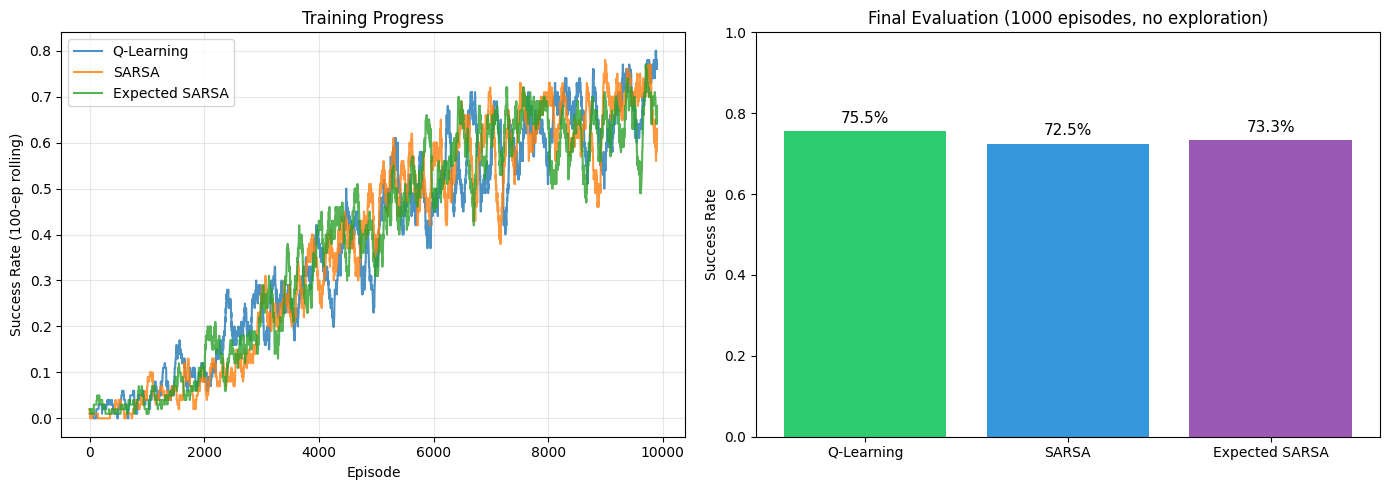

In [5]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Success rate over training
ax = axes[0]
window = 100
ax.plot(running_mean(q_results['successes'], window), label='Q-Learning', alpha=0.8)
ax.plot(running_mean(sarsa_results['successes'], window), label='SARSA', alpha=0.8)
ax.plot(running_mean(exp_sarsa_results['successes'], window), label='Expected SARSA', alpha=0.8)
ax.set_xlabel('Episode')
ax.set_ylabel('Success Rate (100-ep rolling)')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)

# Final evaluation comparison
ax = axes[1]
agents = ['Q-Learning', 'SARSA', 'Expected SARSA']
scores = [q_eval, sarsa_eval, exp_sarsa_eval]
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars = ax.bar(agents, scores, color=colors)
ax.set_ylabel('Success Rate')
ax.set_title('Final Evaluation (1000 episodes, no exploration)')
ax.set_ylim(0, 1)
for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width()/2, score + 0.02, f'{score:.1%}', 
            ha='center', fontsize=11)

plt.tight_layout()
plt.show()

---
## 4. Visualize Learned Q-Values

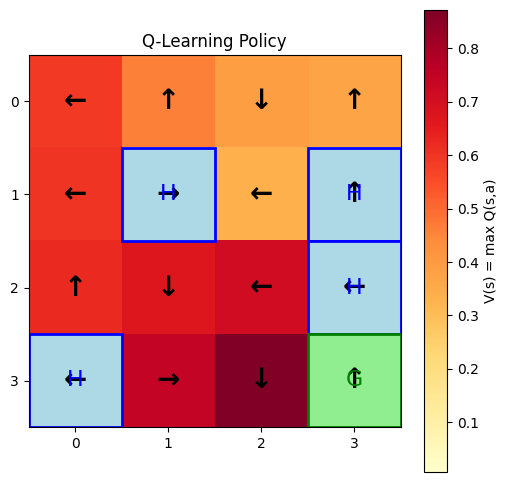

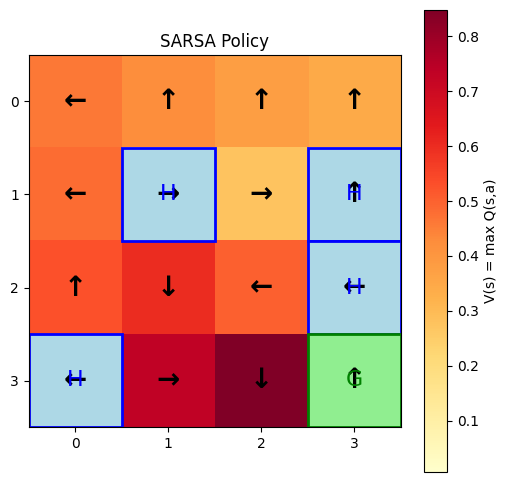

In [6]:
def visualize_policy(q_table, title="Policy"):
    """Visualize the greedy policy from Q-table."""
    action_symbols = ['←', '↓', '→', '↑']
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Get max Q-value for each state (for coloring)
    v = np.max(q_table, axis=1).reshape(4, 4)
    im = ax.imshow(v, cmap='YlOrRd')
    
    # Add arrows for best action
    for s in range(16):
        i, j = s // 4, s % 4
        best_action = np.argmax(q_table[s])
        ax.text(j, i, action_symbols[best_action], ha='center', va='center', 
                fontsize=20, fontweight='bold')
    
    # Mark holes and goal
    holes = [(1, 1), (1, 3), (2, 3), (3, 0)]
    for (i, j) in holes:
        ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, 
                                    facecolor='lightblue', edgecolor='blue', linewidth=2))
        ax.text(j, i, 'H', ha='center', va='center', fontsize=16, color='blue')
    
    ax.add_patch(plt.Rectangle((3-0.5, 3-0.5), 1, 1, fill=True,
                                facecolor='lightgreen', edgecolor='green', linewidth=2))
    ax.text(3, 3, 'G', ha='center', va='center', fontsize=16, color='green')
    
    ax.set_title(title)
    ax.set_xticks(range(4))
    ax.set_yticks(range(4))
    plt.colorbar(im, label='V(s) = max Q(s,a)')
    return fig

fig = visualize_policy(q_results['q_table'], "Q-Learning Policy")
plt.show()

fig = visualize_policy(sarsa_results['q_table'], "SARSA Policy")
plt.show()

---
## 5. The Cliff Walking Example

The classic example showing on-policy vs off-policy difference.

```
Start: S        Goal: G
Grid with cliff at bottom (falling = -100 reward)

S . . . . . . . . . . G
C C C C C C C C C C C C  (Cliff)
```

- **Q-Learning**: Learns the optimal path (right along the cliff edge) but during training, exploration causes falls
- **SARSA**: Learns a safer path (away from cliff) because it accounts for exploration

In [7]:
# Create CliffWalking environment
cliff_env = gym.make('CliffWalking-v1')

print(f"CliffWalking: {cliff_env.observation_space.n} states, {cliff_env.action_space.n} actions")
print("Actions: 0=Up, 1=Right, 2=Down, 3=Left")

CliffWalking: 48 states, 4 actions
Actions: 0=Up, 1=Right, 2=Down, 3=Left


In [8]:
# Train on CliffWalking
cliff_config = {
    'n_states': cliff_env.observation_space.n,
    'n_actions': cliff_env.action_space.n,
    'learning_rate': 0.5,
    'gamma': 1.0,  # No discounting for this episodic task
    'epsilon': 0.1,  # Fixed exploration
    'epsilon_min': 0.1,
    'epsilon_decay': 1.0,  # No decay
}

n_eps = 500

print("Training Q-Learning on Cliff...")
q_cliff = QLearningAgent(**cliff_config, seed=42)
q_cliff_results = train_agent(q_cliff, cliff_env, n_episodes=n_eps, max_steps=200)

print("Training SARSA on Cliff...")
sarsa_cliff = SarsaAgent(**cliff_config, seed=42)
sarsa_cliff_results = train_agent(sarsa_cliff, cliff_env, n_episodes=n_eps, max_steps=200)

Training Q-Learning on Cliff...
Training SARSA on Cliff...


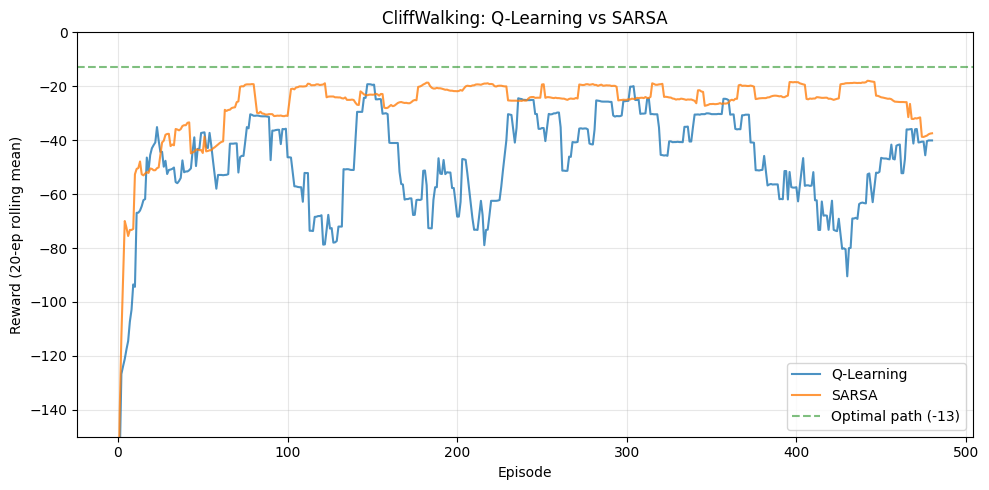


Q-Learning avg reward (last 100): -54.1
SARSA avg reward (last 100): -25.0


In [9]:
# Compare training rewards
fig, ax = plt.subplots(figsize=(10, 5))

window = 20
ax.plot(running_mean(q_cliff_results['rewards'], window), label='Q-Learning', alpha=0.8)
ax.plot(running_mean(sarsa_cliff_results['rewards'], window), label='SARSA', alpha=0.8)
ax.axhline(y=-13, color='green', linestyle='--', label='Optimal path (-13)', alpha=0.5)

ax.set_xlabel('Episode')
ax.set_ylabel('Reward (20-ep rolling mean)')
ax.set_title('CliffWalking: Q-Learning vs SARSA')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-150, 0)

plt.tight_layout()
plt.show()

print(f"\nQ-Learning avg reward (last 100): {np.mean(q_cliff_results['rewards'][-100:]):.1f}")
print(f"SARSA avg reward (last 100): {np.mean(sarsa_cliff_results['rewards'][-100:]):.1f}")

Q-Learning Policy (optimal but risky):


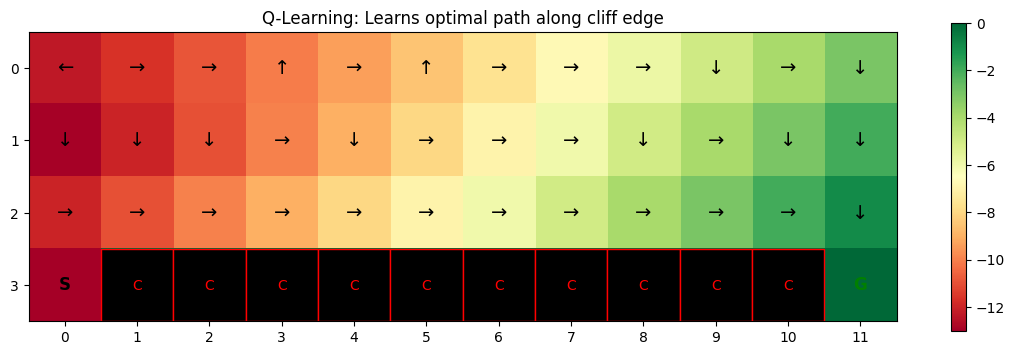


SARSA Policy (safer):


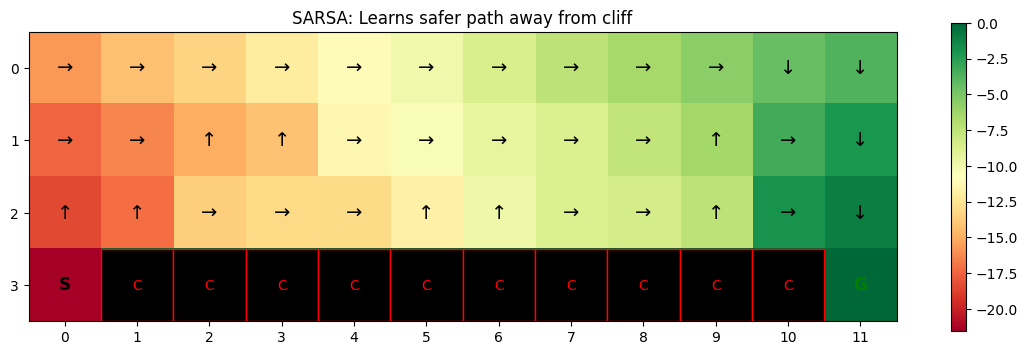

In [10]:
def visualize_cliff_policy(q_table):
    """Visualize CliffWalking policy."""
    action_symbols = ['↑', '→', '↓', '←']
    
    # CliffWalking is 4x12 grid
    policy = np.argmax(q_table, axis=1).reshape(4, 12)
    
    fig, ax = plt.subplots(figsize=(14, 4))
    
    # Color by max Q-value
    v = np.max(q_table, axis=1).reshape(4, 12)
    im = ax.imshow(v, cmap='RdYlGn', aspect='equal')
    
    for i in range(4):
        for j in range(12):
            s = i * 12 + j
            # Mark cliff
            if i == 3 and 0 < j < 11:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True,
                            facecolor='black', edgecolor='red', linewidth=1))
                ax.text(j, i, 'C', ha='center', va='center', color='red', fontsize=10)
            # Mark start
            elif i == 3 and j == 0:
                ax.text(j, i, 'S', ha='center', va='center', fontsize=12, fontweight='bold')
            # Mark goal
            elif i == 3 and j == 11:
                ax.text(j, i, 'G', ha='center', va='center', fontsize=12, fontweight='bold', color='green')
            else:
                ax.text(j, i, action_symbols[policy[i, j]], ha='center', va='center', fontsize=14)
    
    ax.set_xticks(range(12))
    ax.set_yticks(range(4))
    plt.colorbar(im)
    return fig

print("Q-Learning Policy (optimal but risky):")
fig = visualize_cliff_policy(q_cliff_results['q_table'])
plt.title("Q-Learning: Learns optimal path along cliff edge")
plt.show()

print("\nSARSA Policy (safer):")
fig = visualize_cliff_policy(sarsa_cliff_results['q_table'])
plt.title("SARSA: Learns safer path away from cliff")
plt.show()

---
## 6. Key Takeaways

### Q-Learning (Off-Policy)
- Learns optimal Q-values regardless of behavior policy
- Better for finding the theoretically best policy
- Can be more sample efficient (reuse data)
- May perform worse during training if exploration is costly

### SARSA (On-Policy)
- Learns Q-values for the policy being followed
- More conservative and "safer" in risky environments
- Better when exploration has real costs
- Generally more stable training

### Expected SARSA
- Best of both worlds: on-policy style with reduced variance
- Often outperforms both Q-learning and SARSA
- Computationally more expensive per update

### When to Use What
| Scenario | Recommended |
|----------|-------------|
| Safe simulation, want optimal policy | Q-Learning |
| Real-world with dangerous states | SARSA |
| Best average performance | Expected SARSA |
| Off-policy data (demos, replays) | Q-Learning |

---
## Next Up: Deep Q-Networks (DQN)

Tabular methods don't scale. What if we have millions of states?

→ Use neural networks to approximate Q(s, a)!